# State Level Comparisons
This notebook is useful for comparing key COVID-19 statistics across a subset of states.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [2]:
try:
    # read directly from NYT's github repo for the freshest data
    states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
except:
    # unless it's not available in which case read locally after pulling the repo from upstream
    # (assumes you've added the NYT repo as upstream with 
    #     $ remote add upstream https://github.com/nytimes/covid-19-data.git)
    !git pull upstream master
    states = pd.read_csv('us-states.csv')

In [3]:
# drop the fips columns since we don't need it
states.drop(columns='fips',inplace=True)
states.head()

,date,state,cases,deaths
0,2020-01-21,Washington,1,0
1,2020-01-22,Washington,1,0
2,2020-01-23,Washington,1,0
3,2020-01-24,Illinois,1,0
4,2020-01-24,Washington,1,0


In [4]:
# compute the new cases and new deaths per state
start = '2020-01-20'
los = states.state.unique()
for state in los:
    tmp = pd.concat([pd.DataFrame([{'state': state, 'date': start, 'cases': 0, 'deaths': 0}]),states[states.state == state]])
    # compute new cases and deaths
    states.loc[tmp.index,'new_cases'] = tmp['cases'] - tmp['cases'].shift(1)
    states.loc[tmp.index,'new_deaths'] = tmp['deaths'] - tmp['deaths'].shift(1)
    
    states.loc[tmp.index,'nc7d'] = states.loc[tmp.index,'new_cases'].rolling(window=7).mean()
    states.loc[tmp.index,'nd7d'] = states.loc[tmp.index,'new_deaths'].rolling(window=7).mean()
states.replace(np.nan,0,inplace=True)

In [5]:
# get state populations and other variables
state_populations = pd.read_csv('state population and area.csv')
state_populations.head()

,State,TotalArea,LandArea,WaterArea,Density,Pop
0,Alaska,665384,570641,94743,1.2863,734002
1,Texas,268596,261232,7365,112.8204,29472295
2,California,163696,155779,7916,256.3727,39937489
3,Montana,147040,145546,1494,7.4668,1086759
4,New Mexico,121590,121298,292,17.2850,2096640


In [6]:
state_totals = states.groupby('state')\
    .agg({'deaths': max, 'cases': max})\
    .merge(state_populations,left_index=True,right_on='State')[['State','Pop','deaths','cases']]
state_totals.set_index('State',inplace=True)
state_totals['cfr'] = state_totals['deaths'] / state_totals['cases']
state_totals['deaths_per_million'] = 1E6*state_totals['deaths'] / state_totals['Pop']
state_totals['% infected'] = 100 * state_totals['cases'] / state_totals['Pop']
state_totals.head()

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Alabama,4908621,93,3583,0.025956,18.946258,0.072994
Alaska,734002,6,270,0.022222,8.174365,0.036785
Arizona,7378494,117,3539,0.033060,15.856894,0.047964
Arkansas,3038999,27,1280,0.021094,8.884504,0.042119
California,39937489,676,23323,0.028984,16.926452,0.058399


In [7]:
# define a function to pretty print a dataframe
def pprint(df):
    display(HTML(df.to_html()))

In [8]:
# function to space the tick labels on the x axis and optionally rotate them
def space_x_ticks(ax,n,rotation=0):
    xticks=ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i%n != 0:
            xticks[i].set_visible(False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=rotation)

In [9]:
# function to make a 2x2 grid of plots showing new and total cases and deaths for a list of states
def compare_states(los,title_suffix=''):
    tmp = states.loc[states.state.isin(los)]
    
    #find the earliest date when any state in the list had 10 total cases
    start = tmp.loc[tmp.cases >= 10,'date'].min()
    tmp = tmp[tmp.date >= start]
    
    fig, axes = plt.subplots(2, 2, sharex='col',figsize=(10,8))
    suptitle = 'COVID-19 Counts'+' - '+title_suffix if title_suffix else 'COVID-19 Counts'
    fig.suptitle(suptitle, fontsize=14, y=1.05);
    plt.tight_layout(pad=0.4, w_pad=0, h_pad=1.0)
    
    # top left
    ax = axes[0,0]
    sns.lineplot(data=tmp,x='date',y='nc7d',hue='state',ax=ax)
    ax.set_ylabel('Cases')
    ax.set_title('New per Day (7 day moving average)')
    ax.set_yscale('log')
    space_x_ticks(ax,7,45)
    ax.grid(True,axis='both')
    ax.tick_params(axis='x',direction='in')
    
    # top right
    ax = axes[0,1]
    sns.lineplot(x=tmp.date,y=tmp.cases,hue=tmp.state,ax=ax,legend=False)
    ax.get_yaxis().label.set_visible(False)
    ax.set_title('Total')
    ax.set_yscale('log')
    space_x_ticks(ax,7,45)
    ax.grid(True,axis='both')
    ax.tick_params(axis='x',direction='in')
    
    # bottom left
    ax = axes[1,0]
    sns.lineplot(x=tmp.date,y=tmp.nd7d,hue=tmp.state,ax=ax,legend=False)
    ax.set_ylabel('Deaths')
    ax.set_yscale('log')
    space_x_ticks(ax,7,45)
    ax.grid(True,axis='both')
    ax.tick_params(axis='x',direction='in')
    ax.get_xaxis().label.set_visible(False)
    
    
    # bottom right
    ax = axes[1,1]
    sns.lineplot(x=tmp.date,y=tmp.deaths,hue=tmp.state,ax=ax,legend=False)
    ax.get_yaxis().label.set_visible(False)
    ax.set_yscale('log')
    space_x_ticks(ax,7,45)
    ax.grid(True,axis='both')
    ax.tick_params(axis='x',direction='in')
    ax.get_xaxis().label.set_visible(False)
    
    pprint(state_totals.loc[state_totals.index.isin(los)])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
California,39937489,676,23323,0.028984,16.926452,0.058399
Nevada,3139658,113,2860,0.039510,35.991181,0.091093
Oregon,4301089,52,1527,0.034054,12.089961,0.035503
Washington,7797095,511,10411,0.049083,65.537229,0.133524


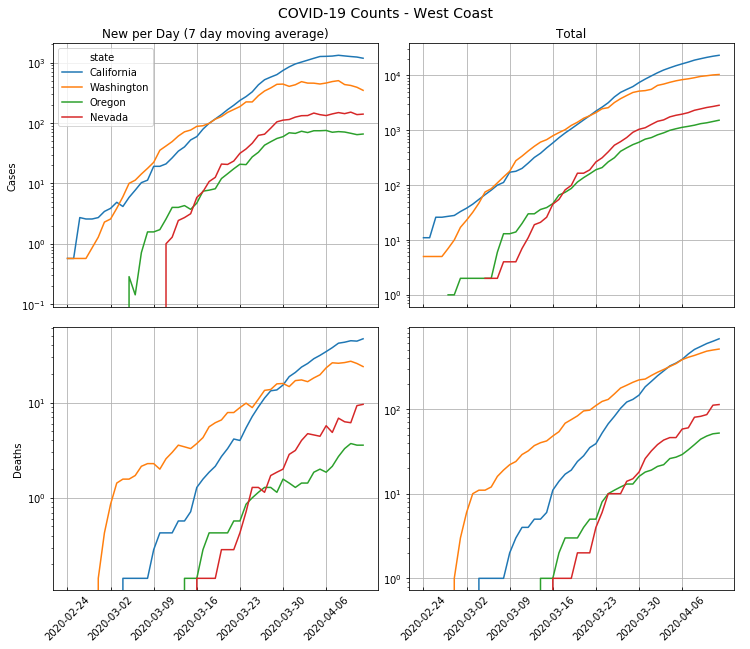

In [10]:
compare_states(['California','Oregon','Washington','Nevada'],'West Coast')

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Illinois,12659682,727,20852,0.034865,57.426403,0.164712
Indiana,6745354,343,7928,0.043264,50.849815,0.117533
Michigan,10045029,1486,24494,0.060668,147.933869,0.243842
Ohio,11747694,253,6604,0.038310,21.536141,0.056215


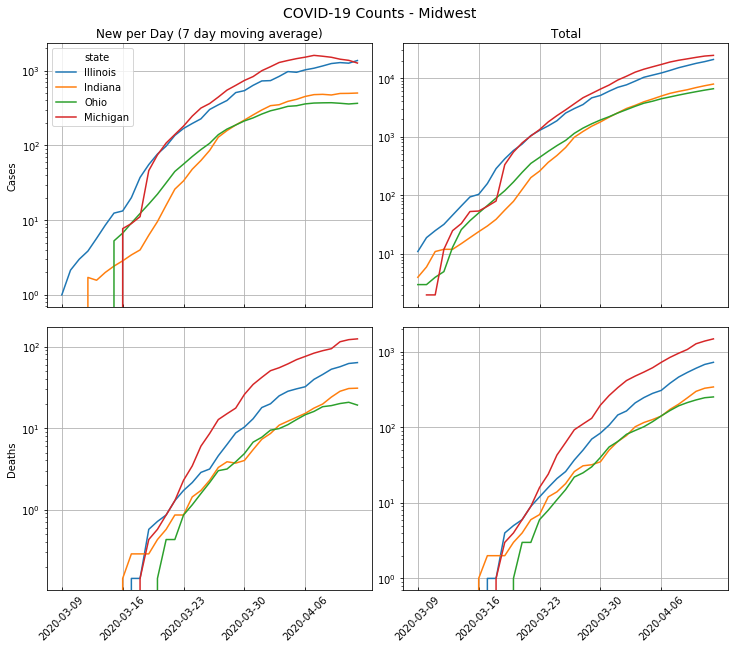

In [11]:
compare_states(['Illinois','Indiana','Michigan','Ohio'],'Midwest')

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
California,39937489,676,23323,0.028984,16.926452,0.058399
New York,19440469,9385,188694,0.049737,482.755843,0.970625


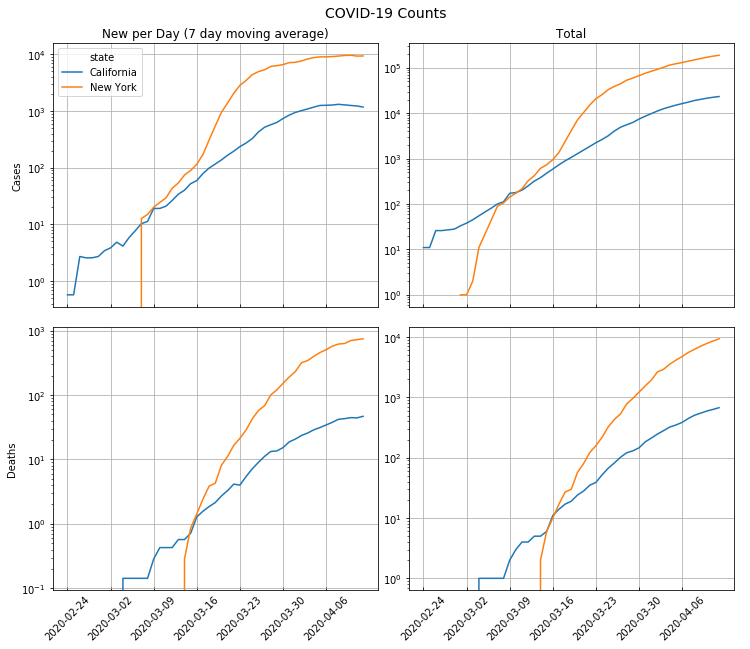

In [12]:
compare_states(['California','New York'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Connecticut,3563077,554,12035,0.046032,155.483589,0.337770
New Jersey,8936574,2350,61850,0.037995,262.964308,0.692100
New York,19440469,9385,188694,0.049737,482.755843,0.970625
Pennsylvania,12820878,525,22955,0.022871,40.948834,0.179044


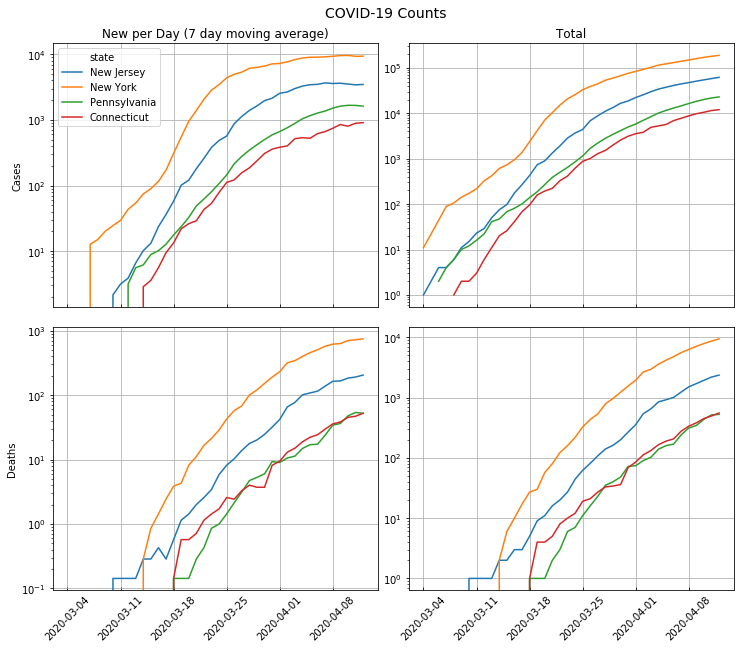

In [13]:
compare_states(['New York','New Jersey','Pennsylvania','Connecticut'])

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Alabama,4908621,93,3583,0.025956,18.946258,0.072994
Georgia,10736059,438,12261,0.035723,40.797093,0.114204
Louisiana,4645184,840,20595,0.040787,180.832449,0.443362
Mississippi,2989260,96,2781,0.034520,32.114972,0.093033


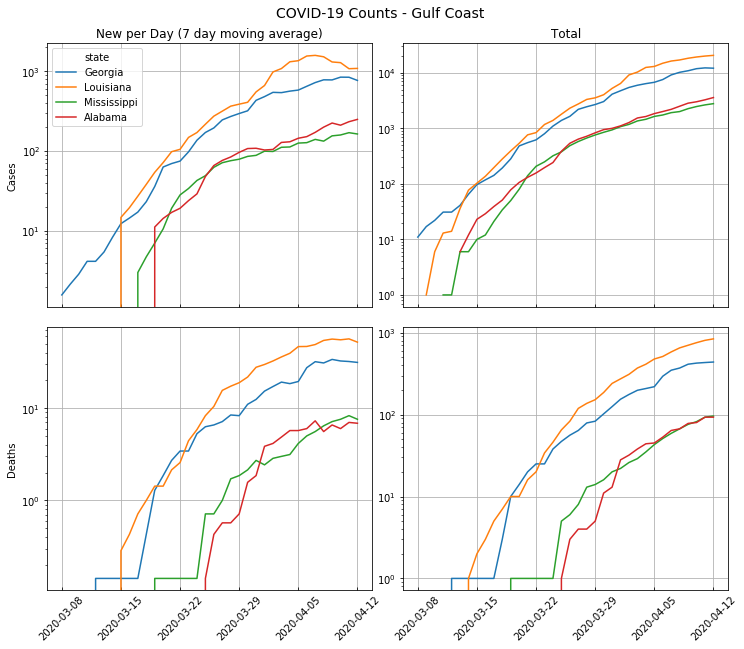

In [14]:
compare_states(['Louisiana','Mississippi','Alabama','Georgia'],'Gulf Coast')

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Arizona,7378494,117,3539,0.033060,15.856894,0.047964
Colorado,5845526,290,7303,0.039710,49.610591,0.124933
New Mexico,2096640,26,1245,0.020884,12.400794,0.059381
Utah,3282115,18,2303,0.007816,5.484269,0.070168


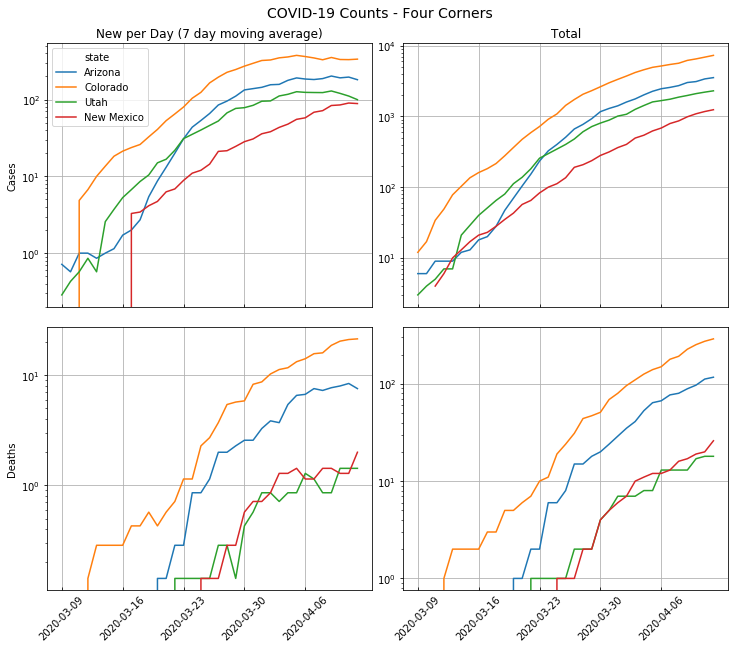

In [15]:
compare_states(['Utah','Colorado','Arizona','New Mexico'],'Four Corners')

,Pop,deaths,cases,cfr,deaths_per_million,% infected
State,,,,,,
Florida,21992985,460,19887,0.023131,20.915760,0.090424
Georgia,10736059,438,12261,0.035723,40.797093,0.114204
North Carolina,10611862,86,4520,0.019027,8.104139,0.042594
South Carolina,5210095,82,3319,0.024706,15.738677,0.063703


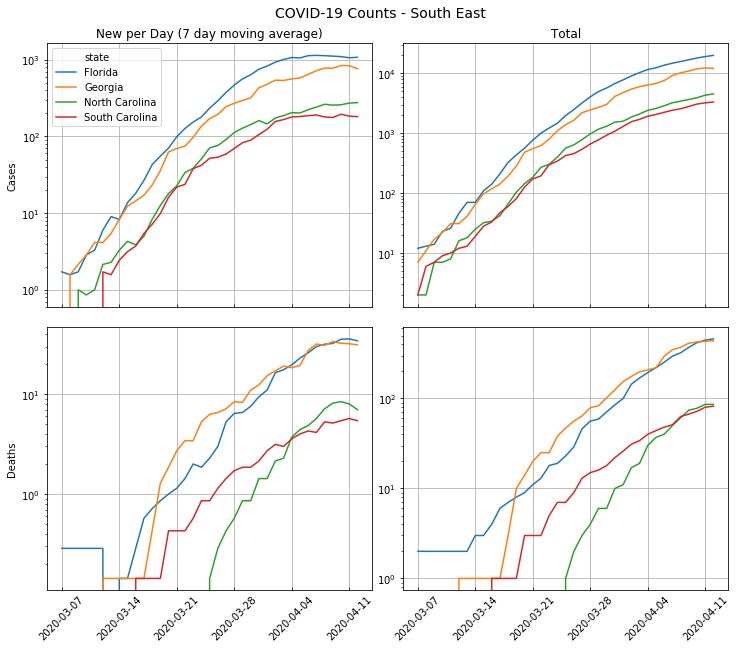

In [16]:
compare_states(['Florida','Georgia','South Carolina','North Carolina'],'South East')